### Fine tune Qwen 2.5 VL for Photonics--Ricky Li, Feb 2025, UIUC
### using simulation images

### Installation

In [1]:
%%capture
import os

%pip install unsloth --user

In [2]:
# install the latest transfomers version
#!pip install git+https://github.com/huggingface/transformers accelerate

### Unsloth

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    #"unsloth/Qwen2.5-VL-3B-Instruct",
    model_name = "pcsel_llm",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    #device_map="auto",
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.9: Fast Qwen2_5_Vl patching. Transformers: 4.50.0.dev0.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.252 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [5]:
#model = FastVisionModel.get_peft_model(
#    model,
#    finetune_vision_layers     = True, # False if not finetuning vision layers
#    finetune_language_layers   = True, # False if not finetuning language layers
#    finetune_attention_modules = True, # False if not finetuning attention layers
#    finetune_mlp_modules       = True, # False if not finetuning MLP layers
    
    #r = 16,           # The larger, the higher the accuracy, but might overfit
    #lora_alpha = 16,  # Recommended alpha == r at least
    #lora_dropout = 0,
    #bias = "none",
    #random_state = 3407,
    #use_rslora = False,  # We support rank stabilized LoRA
    #loftq_config = None, # And LoftQ
    #target_modules = "all-linear", # Optional now! Can specify a list if needed
    
#)

<a name="Data"></a>
### Data Prep

Load the data from: https://huggingface.co/datasets/richardcsuwandi/pcsel

In [6]:
from datasets import load_dataset
# dataset = load_dataset("unsloth/LaTeX_OCR", split="train")
dataset = load_dataset("richardcsuwandi/pcsel", split = "train")

Resolving data files:   0%|          | 0/688 [00:00<?, ?it/s]

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [7]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 687
})

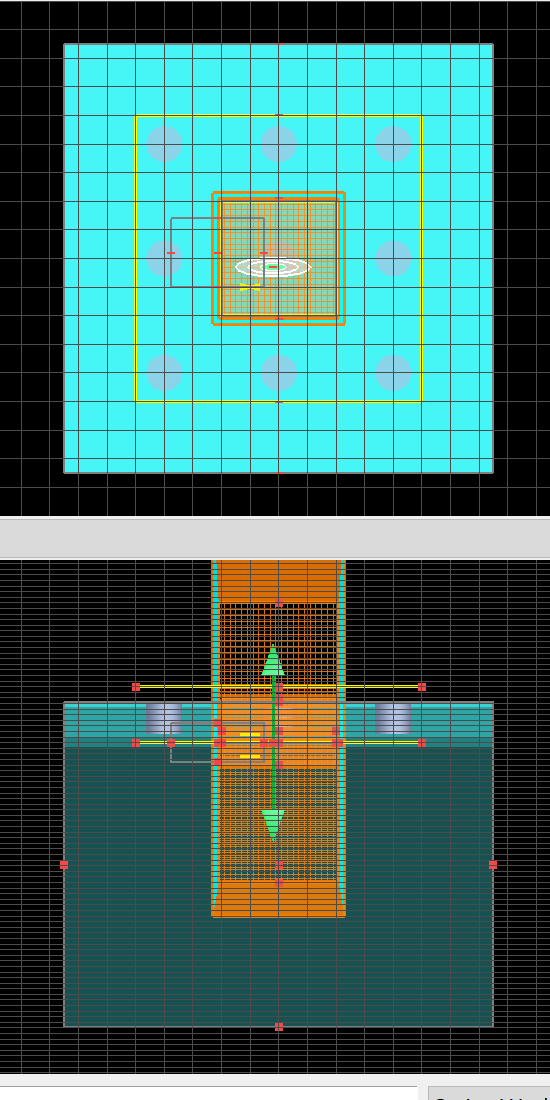

In [8]:
dataset[2]["image"]

In [9]:
dataset[2]["text"]

'PCSEL Optical Properties:\n Q-factor: 15132.119396711265\n Wavelength: 1339.4213738016776 nm\n Divergence Angle: 0.08022007786172546 degrees\n Lasing Area: 8.511294213247848e-14 m²\n Beam Quality: 1.1614879957716027\n Geometry Parameters: -500.0, 100.1, -9.805, -150.7, -0.07743, 0.008932, -0.1028, -97.9'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [10]:
instruction = "Based on the given PCSEL image, predict its optical properties."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

We look at how the conversations are structured for the first example:

In [12]:
converted_dataset[2]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Based on the given PCSEL image, predict its optical properties.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=550x1100>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'PCSEL Optical Properties:\n Q-factor: 15132.119396711265\n Wavelength: 1339.4213738016776 nm\n Divergence Angle: 0.08022007786172546 degrees\n Lasing Area: 8.511294213247848e-14 m²\n Beam Quality: 1.1614879957716027\n Geometry Parameters: -500.0, 100.1, -9.805, -150.7, -0.07743, 0.008932, -0.1028, -97.9'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [13]:
'''
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Based on the given PCSEL image, predict its optical properties."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)
'''

'\nFastVisionModel.for_inference(model) # Enable for inference!\n\nimage = dataset[2]["image"]\ninstruction = "Based on the given PCSEL image, predict its optical properties."\n\nmessages = [\n    {"role": "user", "content": [\n        {"type": "image"},\n        {"type": "text", "text": instruction}\n    ]}\n]\ninput_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)\ninputs = tokenizer(\n    image,\n    input_text,\n    add_special_tokens = False,\n    return_tensors = "pt",\n).to("cuda")\n\nfrom transformers import TextStreamer\ntext_streamer = TextStreamer(tokenizer, skip_prompt = True)\n_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,\n                   use_cache = True, temperature = 1.5, min_p = 0.1)\n'

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [14]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 60,
        num_train_epochs = 5, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [15]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.252 GB.
3.859 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 687 | Num Epochs = 5 | Total steps = 430
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928/2,543,708,160 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.699500
2,2.679000
3,2.235900
4,1.637400
5,1.251200
6,1.001100
7,0.916800
8,0.883800
9,0.825600
10,0.797500


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3562.9013 seconds used for training.
59.38 minutes used for training.
Peak reserved memory = 9.77 GB.
Peak reserved memory for training = 5.911 GB.
Peak reserved memory % of max memory = 12.328 %.
Peak reserved memory for training % of max memory = 7.458 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [18]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Based on the given PCSEL image, predict its optical properties."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

PCSEL Optical Properties:
 Q-factor: -558795.610215641
 Wavelength: 1387.106261785372 nm
 Divergence Angle: 0.003947253504364868 degrees
 Lasing Area: 8.581948138787853e-14 m²
 Beam Quality: 0.575839502711721



<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [19]:
model.save_pretrained("pcsel_llm")  # Local saving
tokenizer.save_pretrained("pcsel_llm")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [20]:
from datasets import load_dataset
# dataset = load_dataset("unsloth/LaTeX_OCR", split="train")
dataset = load_dataset("richardcsuwandi/pcsel", split = "train")

Resolving data files:   0%|          | 0/688 [00:00<?, ?it/s]

In [21]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "pcsel_llm", # YOUR MODEL YOU USED FOR TRAINING
        device_map="auto",
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Based on the given PCSEL image, predict its optical properties."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

PCSEL Optical Properties:
 Q-factor: 101476.01239904
 Wavelength: 1406.1854344449938 nm
 Divergence Angle: 7.676770079859204e-13 degrees
 Lasing Area: 8.820486992423314e-14 m²
 Beam Quality: 1.16151618508207

